In [55]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from scipy import stats

%matplotlib inline
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook as tq

#pd.set_option("display.max_rows", 100)

In [160]:
def make_df():
    columns = ["状況", "回"]
    event_list = []
    for file in tq(os.listdir("./game_num_data/")[1:]):
        curr_event_list = pd.read_csv("./game_num_data/"+file, encoding="cp932", index_col=0, dtype="object")[columns].values.tolist()
        new_event_list = []
        for i in range(len(curr_event_list)):
            new_event_list.append(curr_event_list[i])
            if i < len(curr_event_list)-1 and curr_event_list[i][0] == "2" and curr_event_list[i+1][0] == "1":
                new_event_list.append(["3000", curr_event_list[i][1]])
                new_event_list.append(["0000", curr_event_list[i+1][1]])
        event_list.extend(new_event_list+[["GAMESET", np.nan]])
    for i in range(len(event_list)):
        if event_list[i][1] is np.nan:
            if event_list[i][0] != "GAMESET":
                event_list[i][1] = event_list[i-1][1]
    return pd.DataFrame(event_list, columns=columns)

In [167]:
event_df = make_df()

In [206]:
event_df.head()

,状況,回
0,0000,1回表
1,1000,1回表
2,2000,1回表
3,3000,1回表
4,0000,1回裏


In [164]:
def decode_count(count):
    out = count[0]
    base = list(count[1:])
    out_comment = str(out) + "アウト"
    if out_comment == "3アウト":
        return out_comment + "チェンジ"
    if base == ["0", "0", "0"]:
        return out_comment + "ランナーなし"
    elif base == ["1", "1", "1"]:
        return out_comment + "満塁"
    base = [elem=="1" for elem in base]
    base_comment = ""
    for i in range(3):
        if base[i]:
            base_comment += str(i+1)
    return out_comment + base_comment + "塁"

In [177]:
def bar_and_df(ad_before, dis_before, after, triple_transfer_list):
    ad = pd.DataFrame(sorted([[elem[0][0], elem[0][1], elem[0][2], elem[1]] for elem in list(Counter([elem for elem in triple_transfer_list if elem[0]==ad_before and elem[1]==after]).items())], key=lambda x: -x[-1]))
    dis = pd.DataFrame(sorted([[elem[0][0], elem[0][1], elem[0][2], elem[1]] for elem in list(Counter([elem for elem in triple_transfer_list if elem[0]==dis_before and elem[1]==after]).items())], key=lambda x: -x[-1]))
    ad[4] = ad[3] / sum(ad[3])
    dis[4] = dis[3] / sum(dis[3])
    con = pd.concat([ad.set_index(2), dis.set_index(2)], axis=1, join="outer").fillna(0)[4]
    con.columns = ["ad_rate", "dis_rate"]

    plt.figure(figsize=(12, 6))
    plt.bar(list(range(len(con.ad_rate))), con.ad_rate, tick_label=[decode_count(elem) for elem in con.index], width=0.35, align="center")
    plt.bar(np.array(list(range(len(con.dis_rate))))+0.35, con.dis_rate, tick_label=[decode_count(elem) for elem in con.index], width=0.35, align="center")
    plt.xticks(rotation=60)
    plt.legend([decode_count(ad[0][0])+"(流れが良い)", decode_count(dis[0][0])+"(流れが悪い)"])
    plt.title(decode_count(ad[1][0]) + "時の結果")
    plt.xlabel("プレーの結果")
    plt.ylabel("割合")
    plt.show()
    
    con = pd.concat([ad.set_index(2), dis.set_index(2)], axis=1, join="outer").fillna(0)[[3, 4]]
    con.columns = ["ad_num", "dis_num", "ad_rate", "dis_rate"]
    con["ad_num"] = con["ad_num"].astype(int)
    con["dis_num"] = con["dis_num"].astype(int)
    con["pvalue"] = [stats.ttest_ind(d1, d2).pvalue for d1, d2 in zip([[0] * (con["ad_num"].sum() - con["ad_num"][idx]) + [1] * con["ad_num"][idx] for idx in con.index], [[0] * (con["dis_num"].sum() - con["dis_num"][idx]) + [1] * con["dis_num"][idx] for idx in con.index])]
    con.index = [decode_count(elem) for elem in con.index]
    display(con.sort_values(by="pvalue"))

In [171]:
former = []
latter = []
for i in range(len(event_df)):
    if event_df.iloc[i, 0] == "GAMESET":
        continue
    if 1 <= int(event_df.iloc[i, 1].split("回")[0]) <= 5:
        former.append(event_df.iloc[i, 0])
    else:
        latter.append(event_df.iloc[i, 0])

In [190]:
inning_list = []
for inning in range(10):
    curr_inning_list = []
    for i in range(len(event_df)):
        if event_df.iloc[i, 0] == "GAMESET":
            continue
        if int(event_df.iloc[i, 1].split("回")[0]) == inning + 1:
            curr_inning_list.append(event_df.iloc[i, 0])
    inning_list.append(curr_inning_list)

In [191]:
len(inning_list)

10

In [186]:
former_triple = []
for i in range(2, len(former)):
    before, curr, after = former[i-2], former[i-1], former[i]
    if "GAMESET" in [before, curr, after]:
        continue
    if before == "3000" or curr == "3000":
        continue
    former_triple.append((before, curr, after))

In [187]:
latter_triple = []
for i in range(2, len(latter)):
    before, curr, after = latter[i-2], latter[i-1], latter[i]
    if "GAMESET" in [before, curr, after]:
        continue
    if before == "3000" or curr == "3000":
        continue
    latter_triple.append((before, curr, after))

In [202]:
inning_triple_list = []
for inning in range(len(inning_list)):
    curr_triple = []
    for i in range(2, len(inning_list[inning])):
        before, curr, after = inning_list[inning][i-2], inning_list[inning][i-1], inning_list[inning][i]
        if "GAMESET" in [before, curr, after]:
            continue
        if before == "3000" or curr == "3000":
            continue
        curr_triple.append((before, curr, after))
    inning_triple_list.append(curr_triple)

In [203]:
len(inning_triple_list[3])

5269

In [204]:
len(inning_triple_list[1])

5192

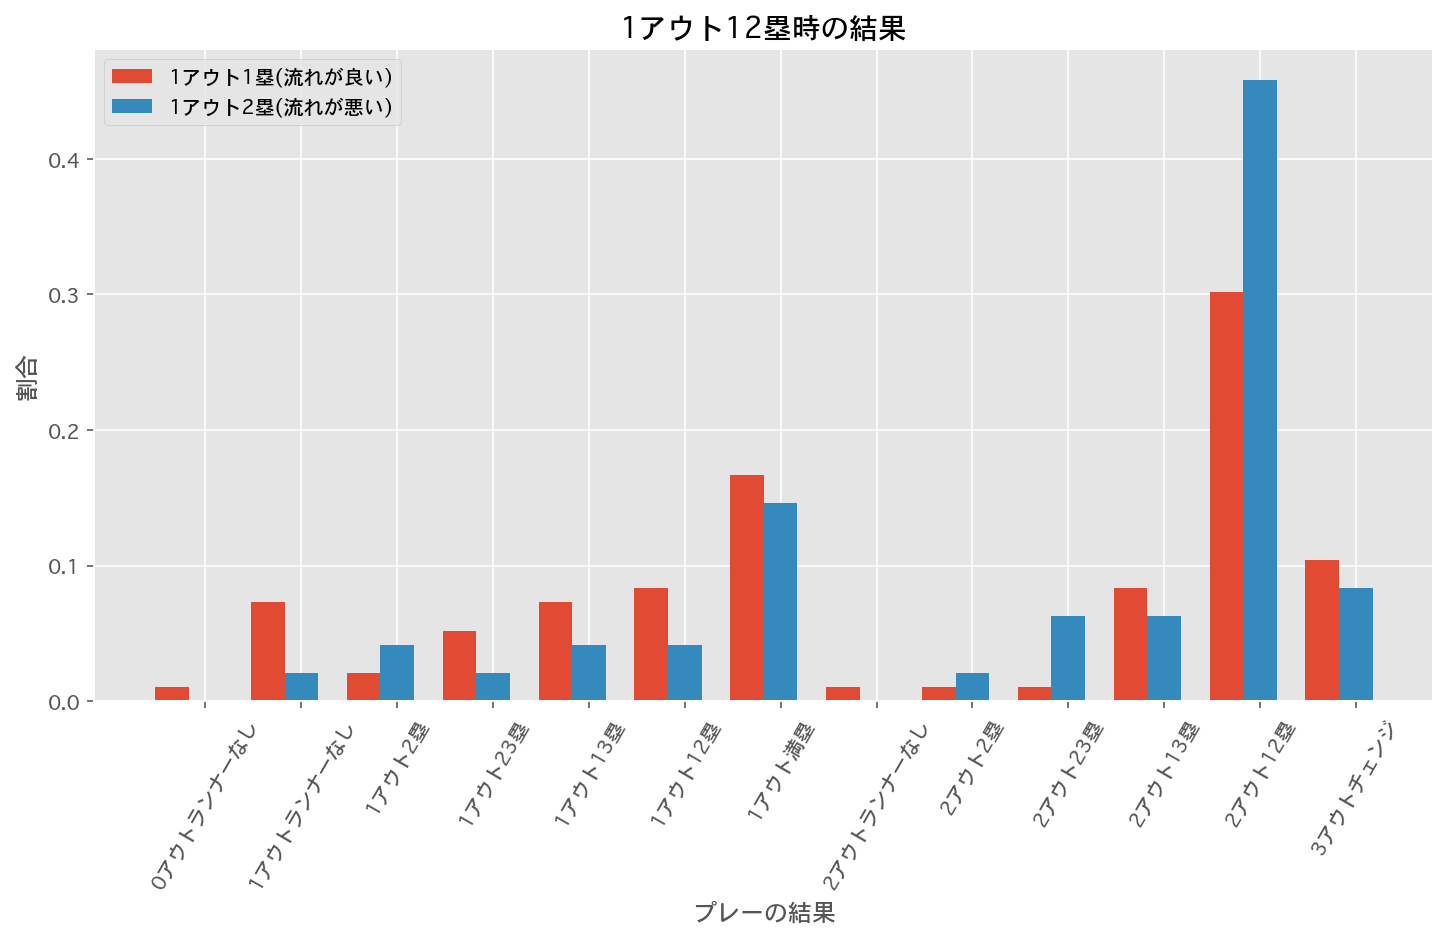

,ad_num,dis_num,ad_rate,dis_rate,pvalue
2アウト12塁,29,22,0.302083,0.458333,0.065325
2アウト23塁,1,3,0.010417,0.062500,0.073895
1アウトランナーなし,7,1,0.072917,0.020833,0.200997
1アウト12塁,8,2,0.083333,0.041667,0.357313
1アウト23塁,5,1,0.052083,0.020833,0.379869
1アウト13塁,7,2,0.072917,0.041667,0.468695
1アウト2塁,2,2,0.020833,0.041667,0.476760
0アウトランナーなし,1,0,0.010417,0.000000,0.481428
2アウトランナーなし,1,0,0.010417,0.000000,0.481428
2アウト2塁,1,1,0.010417,0.020833,0.617540


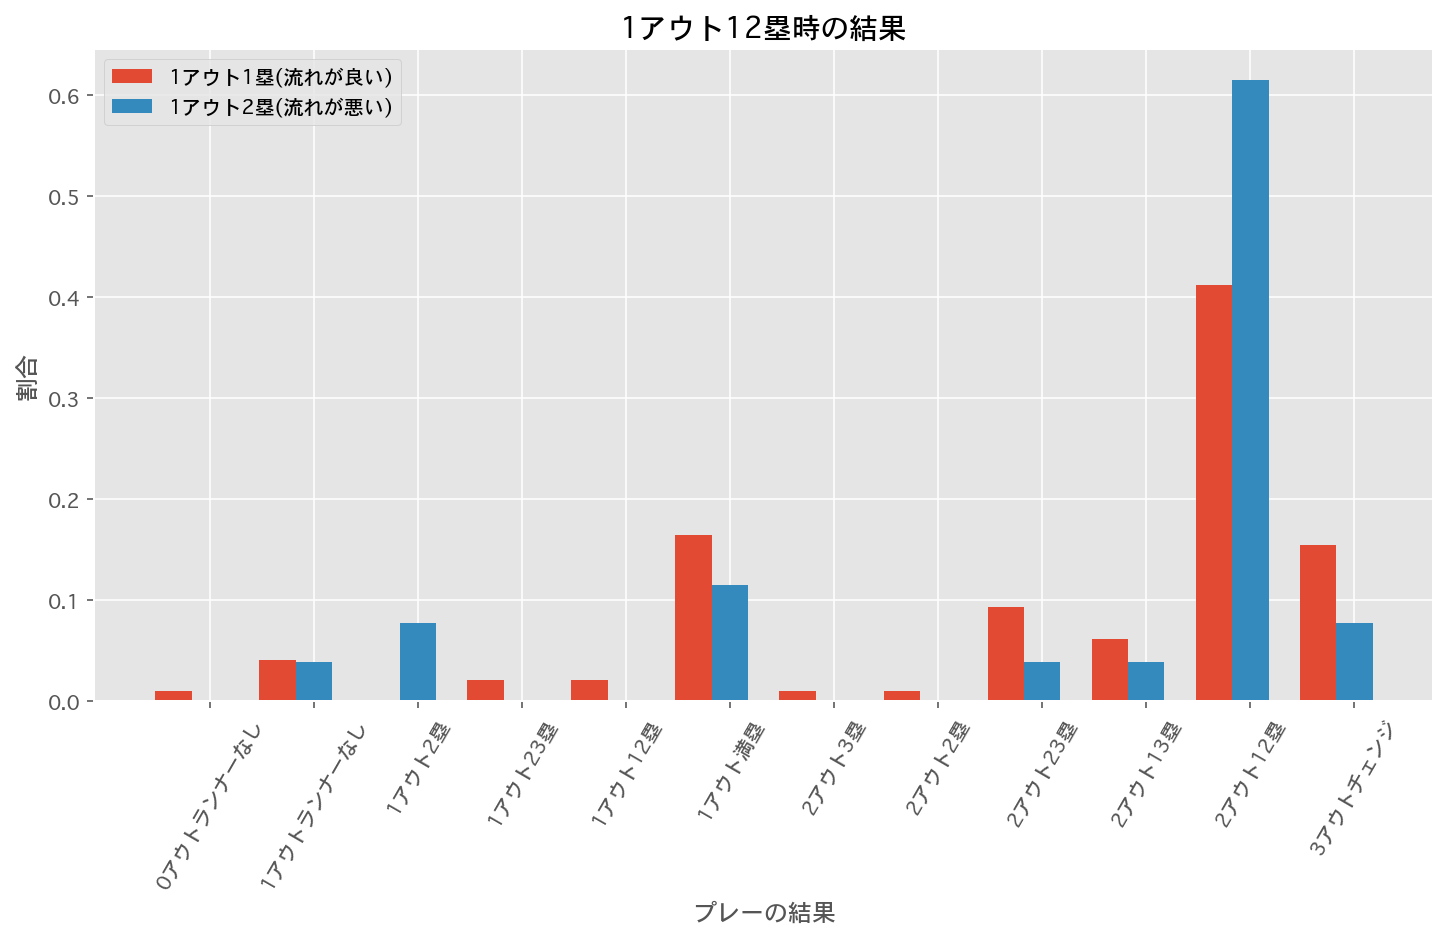

,ad_num,dis_num,ad_rate,dis_rate,pvalue
1アウト2塁,0,2,0.000000,0.076923,0.005615
2アウト12塁,40,16,0.412371,0.615385,0.065775
3アウトチェンジ,15,2,0.154639,0.076923,0.311825
2アウト23塁,9,1,0.092784,0.038462,0.372220
1アウト23塁,2,0,0.020619,0.000000,0.464488
1アウト12塁,2,0,0.020619,0.000000,0.464488
1アウト満塁,16,3,0.164948,0.115385,0.538456
0アウトランナーなし,1,0,0.010309,0.000000,0.606679
2アウト3塁,1,0,0.010309,0.000000,0.606679
2アウト2塁,1,0,0.010309,0.000000,0.606679


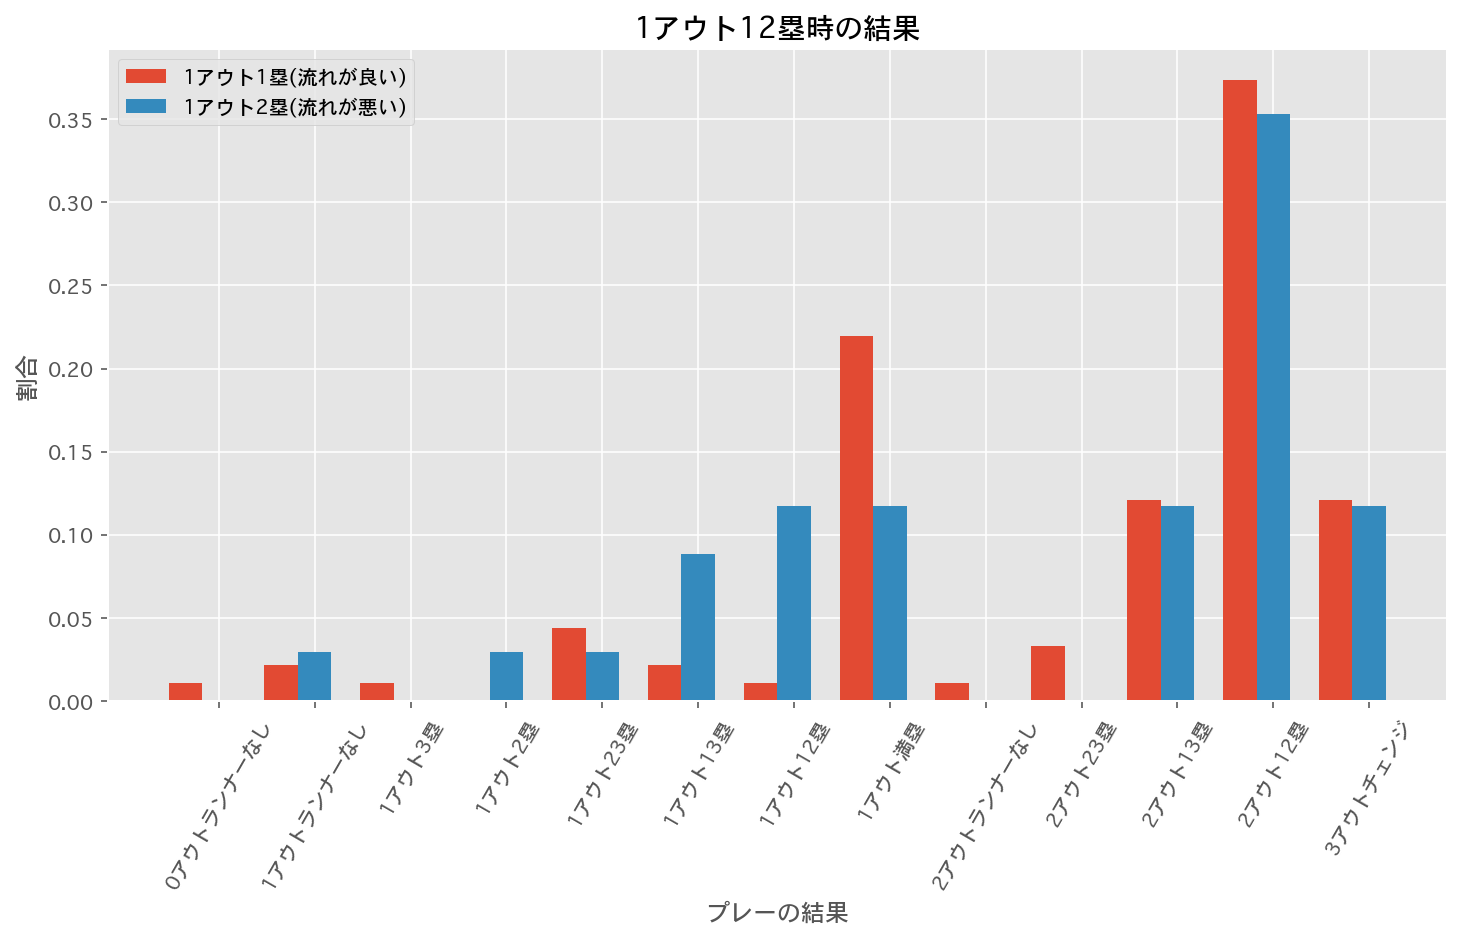

,ad_num,dis_num,ad_rate,dis_rate,pvalue
1アウト12塁,1,4,0.010989,0.117647,0.006502
1アウト13塁,2,3,0.021978,0.088235,0.093967
1アウト2塁,0,1,0.000000,0.029412,0.102058
1アウト満塁,20,4,0.219780,0.117647,0.200053
2アウト23塁,3,0,0.032967,0.000000,0.287629
0アウトランナーなし,1,0,0.010989,0.000000,0.543186
1アウト3塁,1,0,0.010989,0.000000,0.543186
2アウトランナーなし,1,0,0.010989,0.000000,0.543186
1アウト23塁,4,1,0.043956,0.029412,0.714627
1アウトランナーなし,2,1,0.021978,0.029412,0.810914


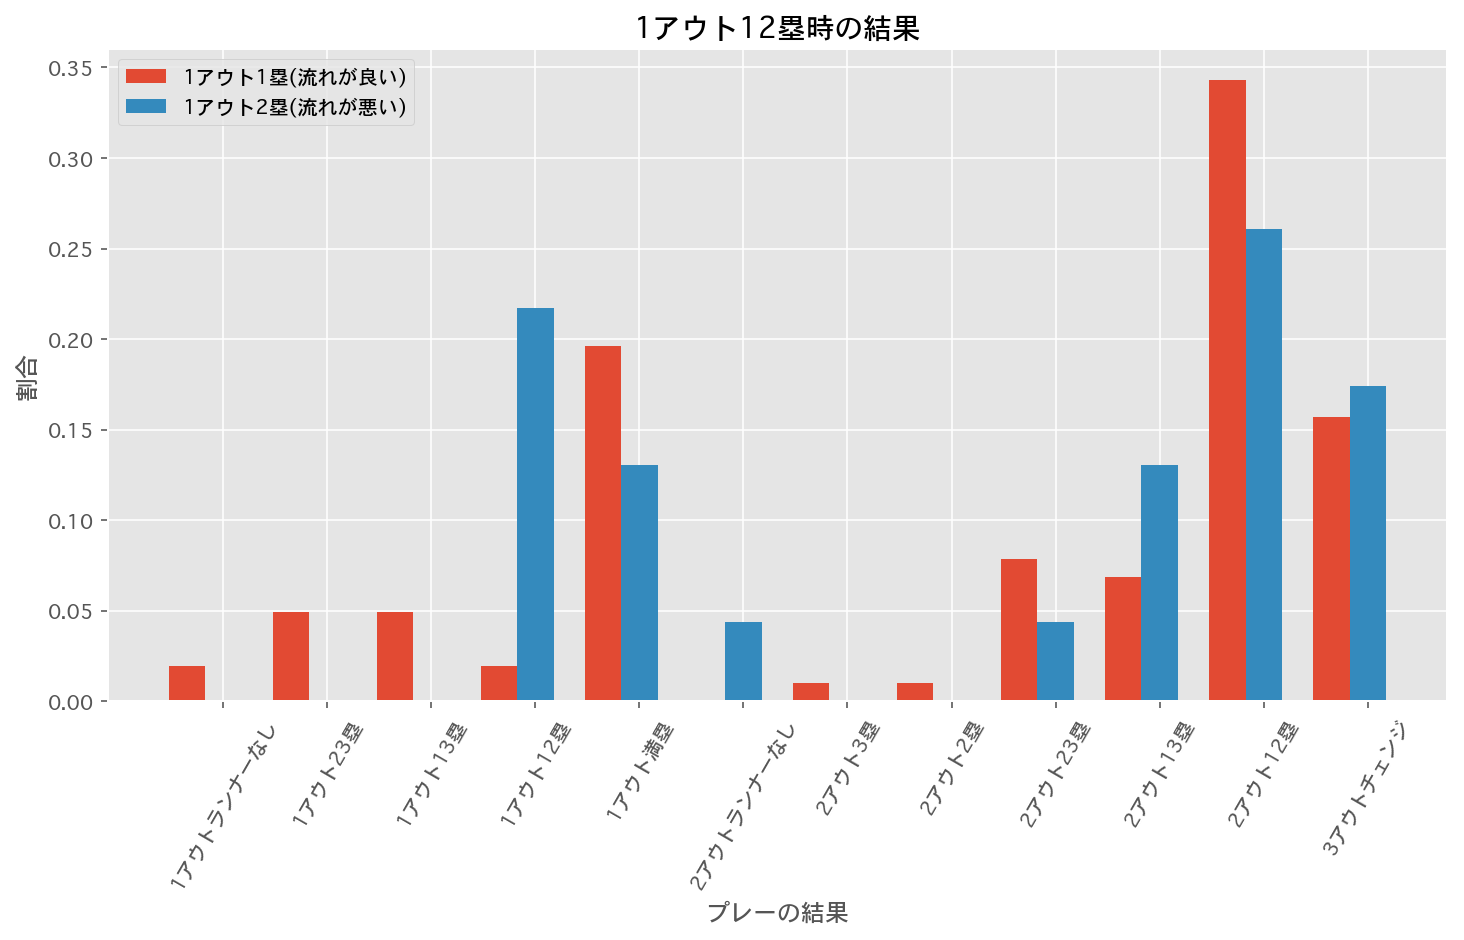

,ad_num,dis_num,ad_rate,dis_rate,pvalue
1アウト12塁,2,5,0.019608,0.217391,0.000146
2アウトランナーなし,0,1,0.000000,0.043478,0.034667
1アウト23塁,5,0,0.049020,0.000000,0.282215
1アウト13塁,5,0,0.049020,0.000000,0.282215
2アウト13塁,7,3,0.068627,0.130435,0.327589
2アウト12塁,35,6,0.343137,0.260870,0.451827
1アウト満塁,20,3,0.196078,0.130435,0.467024
1アウトランナーなし,2,0,0.019608,0.000000,0.502346
2アウト23塁,8,1,0.078431,0.043478,0.561698
2アウト3塁,1,0,0.009804,0.000000,0.636788


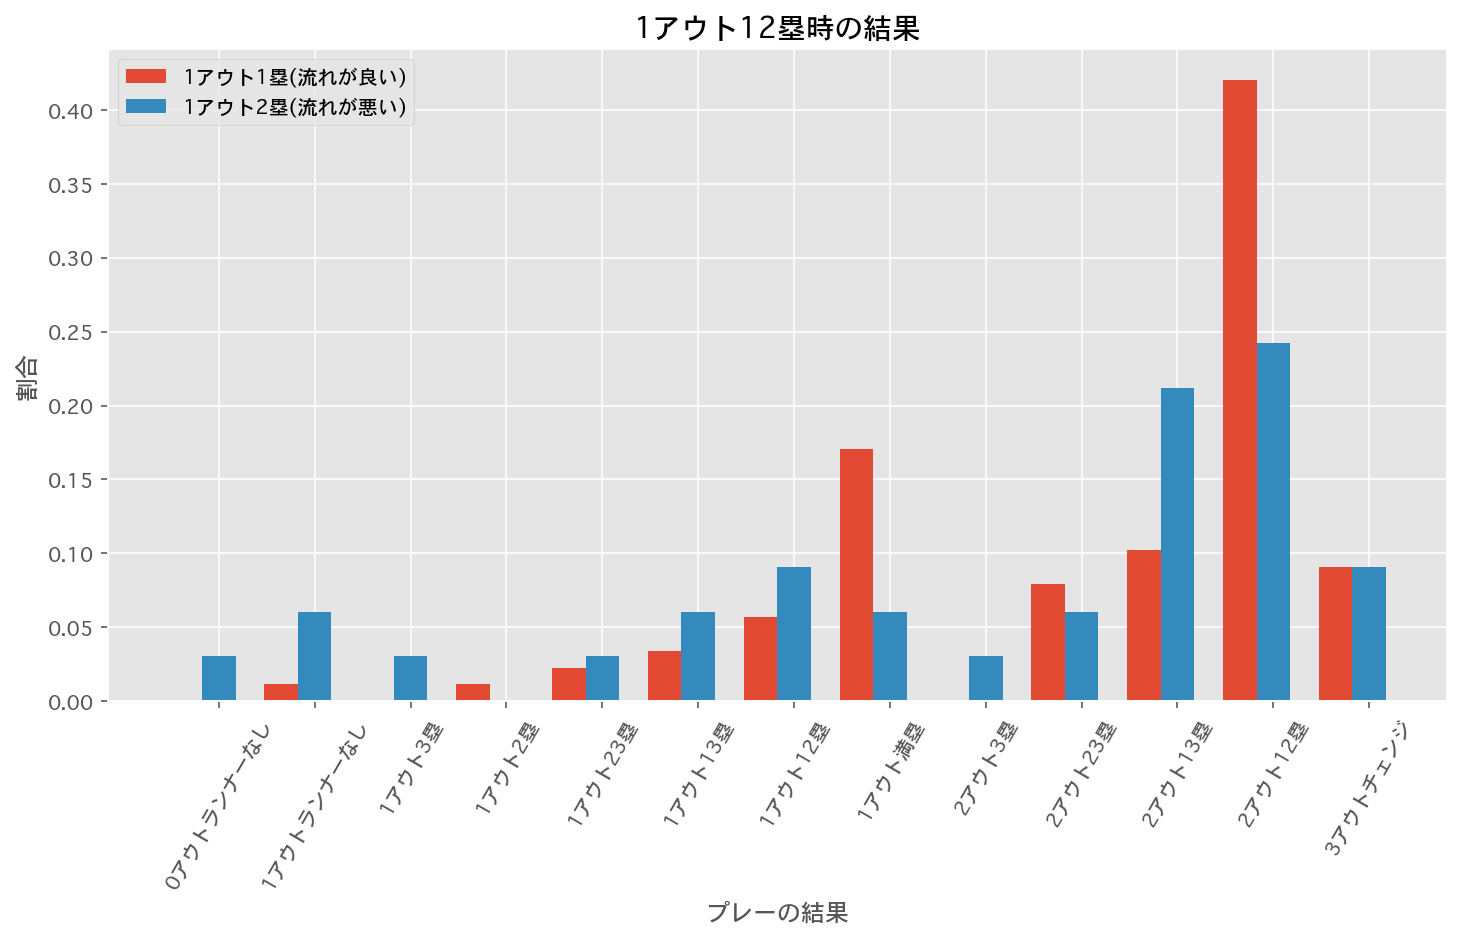

,ad_num,dis_num,ad_rate,dis_rate,pvalue
2アウト12塁,37,8,0.420455,0.242424,0.072172
0アウトランナーなし,0,1,0.000000,0.030303,0.102702
1アウト3塁,0,1,0.000000,0.030303,0.102702
2アウト3塁,0,1,0.000000,0.030303,0.102702
2アウト13塁,9,7,0.102273,0.212121,0.114000
1アウトランナーなし,1,2,0.011364,0.060606,0.122822
1アウト満塁,15,2,0.170455,0.060606,0.123506
1アウト12塁,5,3,0.056818,0.090909,0.505562
1アウト13塁,3,2,0.034091,0.060606,0.518000
1アウト2塁,1,0,0.011364,0.000000,0.542516


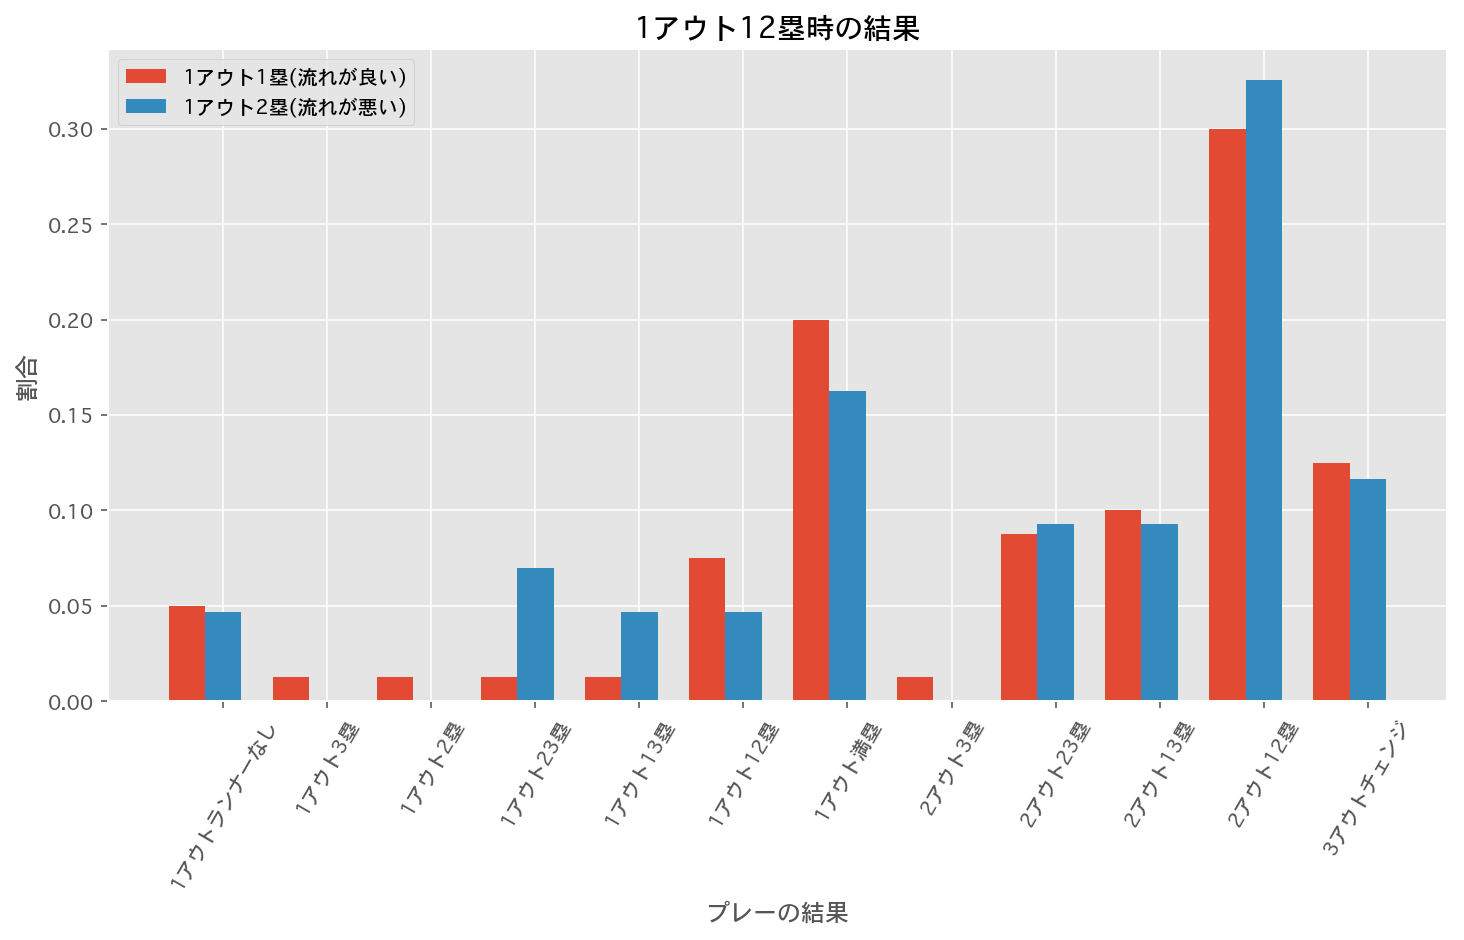

,ad_num,dis_num,ad_rate,dis_rate,pvalue
1アウト23塁,1,3,0.0125,0.069767,0.089108
1アウト13塁,1,2,0.0125,0.046512,0.247137
1アウト3塁,1,0,0.0125,0.000000,0.465738
1アウト2塁,1,0,0.0125,0.000000,0.465738
2アウト3塁,1,0,0.0125,0.000000,0.465738
1アウト12塁,6,2,0.0750,0.046512,0.545065
1アウト満塁,16,7,0.2000,0.162791,0.617223
2アウト12塁,24,14,0.3000,0.325581,0.771931
3アウトチェンジ,10,5,0.1250,0.116279,0.889049
2アウト13塁,8,4,0.1000,0.093023,0.902043


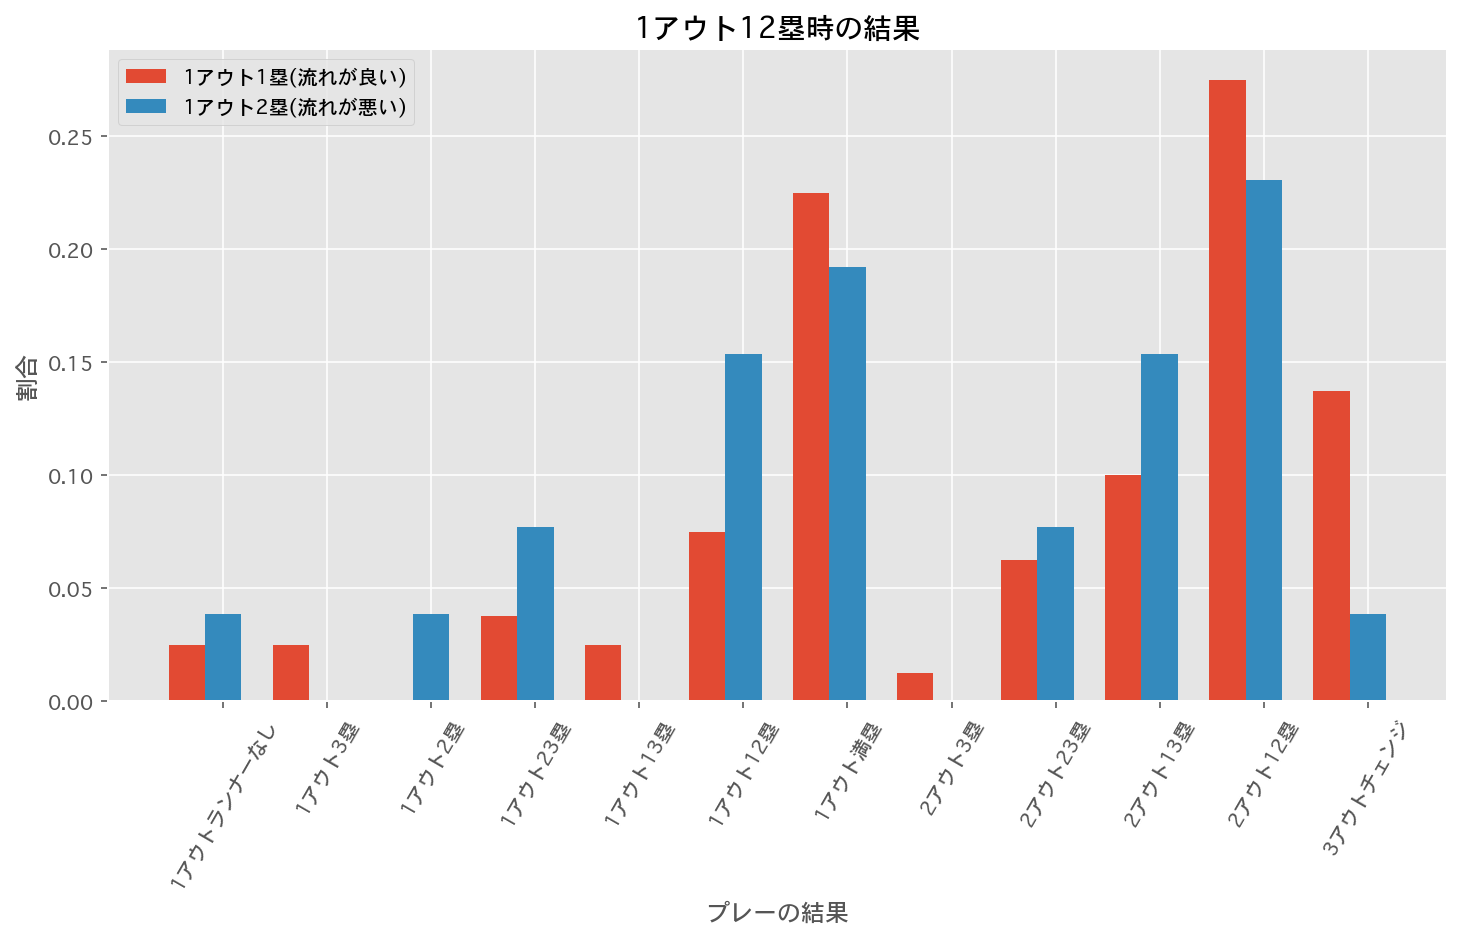

,ad_num,dis_num,ad_rate,dis_rate,pvalue
1アウト2塁,0,1,0.0000,0.038462,0.079340
3アウトチェンジ,11,1,0.1375,0.038462,0.169297
1アウト12塁,6,4,0.0750,0.153846,0.236122
1アウト23塁,3,2,0.0375,0.076923,0.414912
1アウト3塁,2,0,0.0250,0.000000,0.420501
1アウト13塁,2,0,0.0250,0.000000,0.420501
2アウト13塁,8,4,0.1000,0.153846,0.456344
2アウト3塁,1,0,0.0125,0.000000,0.571092
2アウト12塁,22,6,0.2750,0.230769,0.660412
1アウトランナーなし,2,1,0.0250,0.038462,0.722268


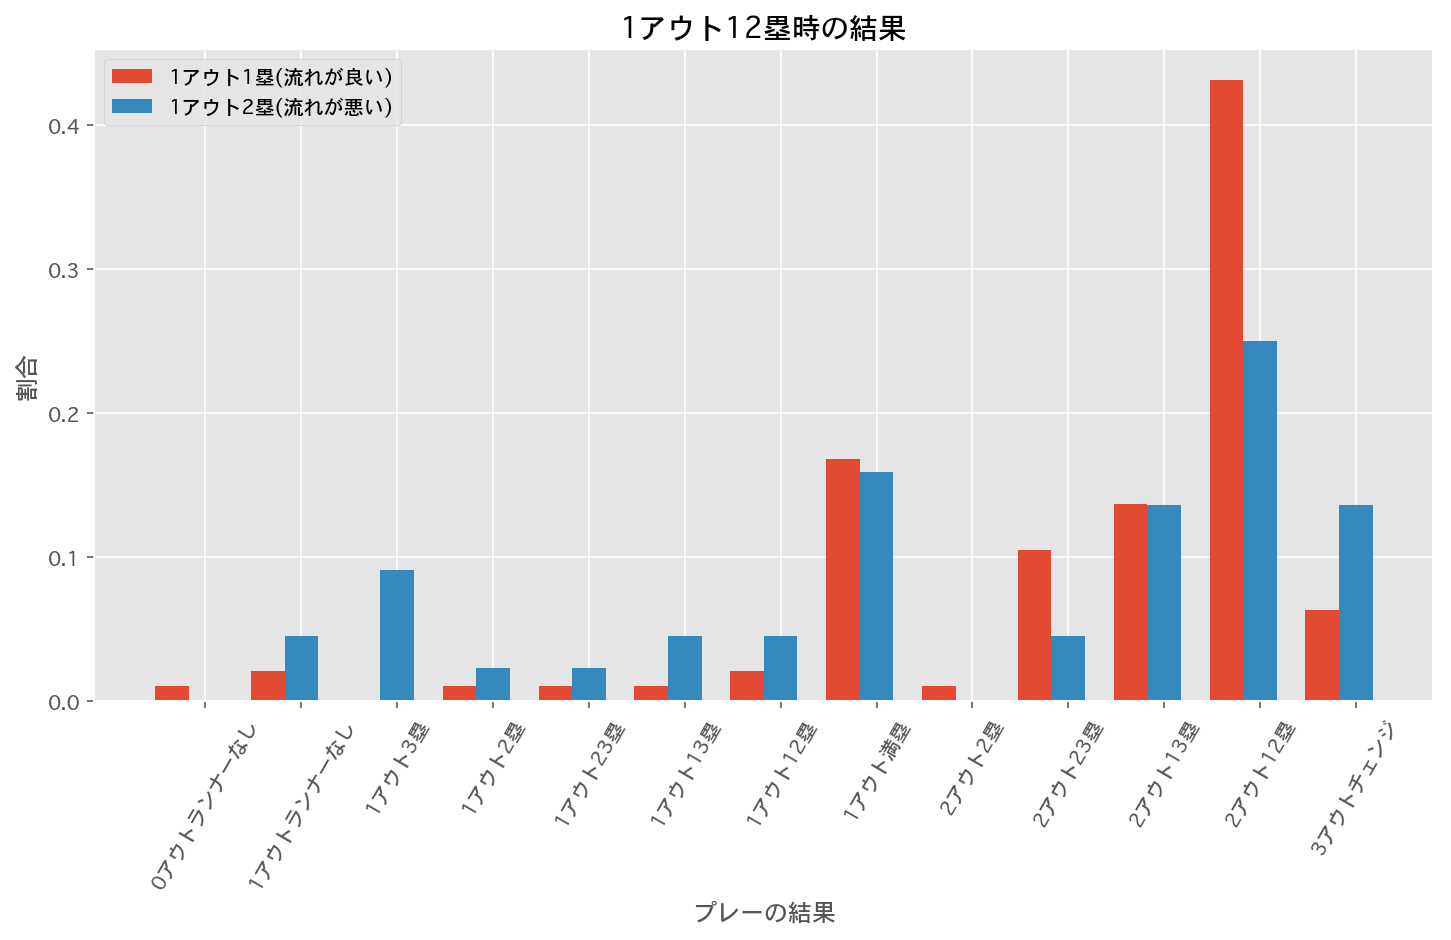

,ad_num,dis_num,ad_rate,dis_rate,pvalue
1アウト3塁,0,4,0.000000,0.090909,0.002664
2アウト12塁,41,11,0.431579,0.250000,0.039879
3アウトチェンジ,6,6,0.063158,0.136364,0.155106
1アウト13塁,1,2,0.010526,0.045455,0.190098
2アウト23塁,10,2,0.105263,0.045455,0.246006
1アウトランナーなし,2,2,0.021053,0.045455,0.427127
1アウト12塁,2,2,0.021053,0.045455,0.427127
0アウトランナーなし,1,0,0.010526,0.000000,0.498140
2アウト2塁,1,0,0.010526,0.000000,0.498140
1アウト2塁,1,1,0.010526,0.022727,0.577469


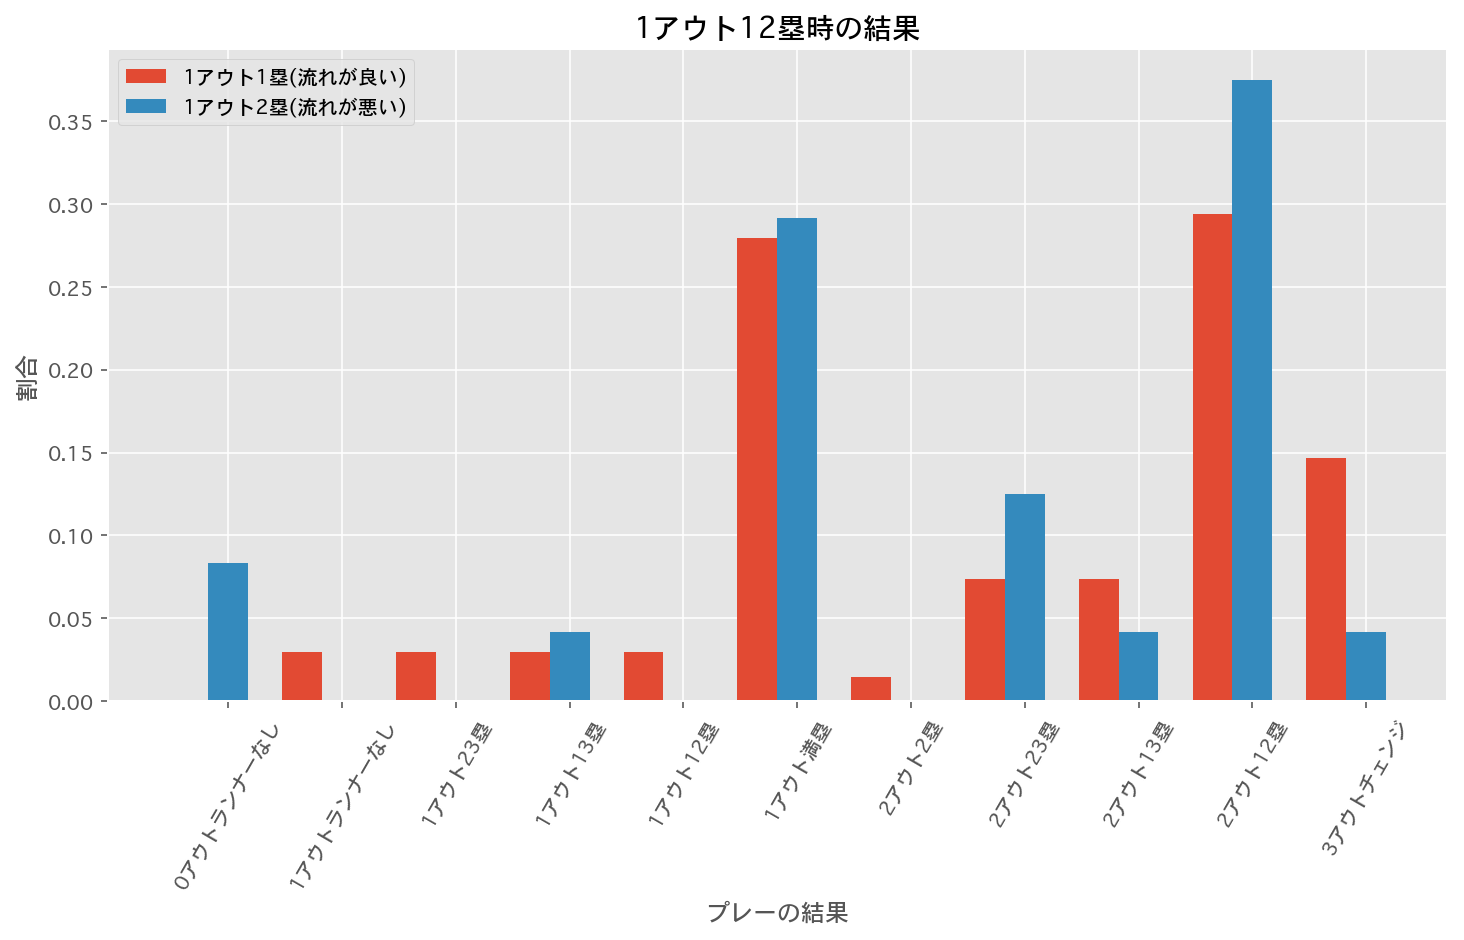

,ad_num,dis_num,ad_rate,dis_rate,pvalue
0アウトランナーなし,0,2,0.000000,0.083333,0.015839
3アウトチェンジ,10,1,0.147059,0.041667,0.174985
1アウトランナーなし,2,0,0.029412,0.000000,0.401195
1アウト23塁,2,0,0.029412,0.000000,0.401195
1アウト12塁,2,0,0.029412,0.000000,0.401195
2アウト23塁,5,3,0.073529,0.125000,0.447216
2アウト12塁,20,9,0.294118,0.375000,0.468904
2アウト2塁,1,0,0.014706,0.000000,0.555359
2アウト13塁,5,1,0.073529,0.041667,0.591602
1アウト13塁,2,1,0.029412,0.041667,0.774341


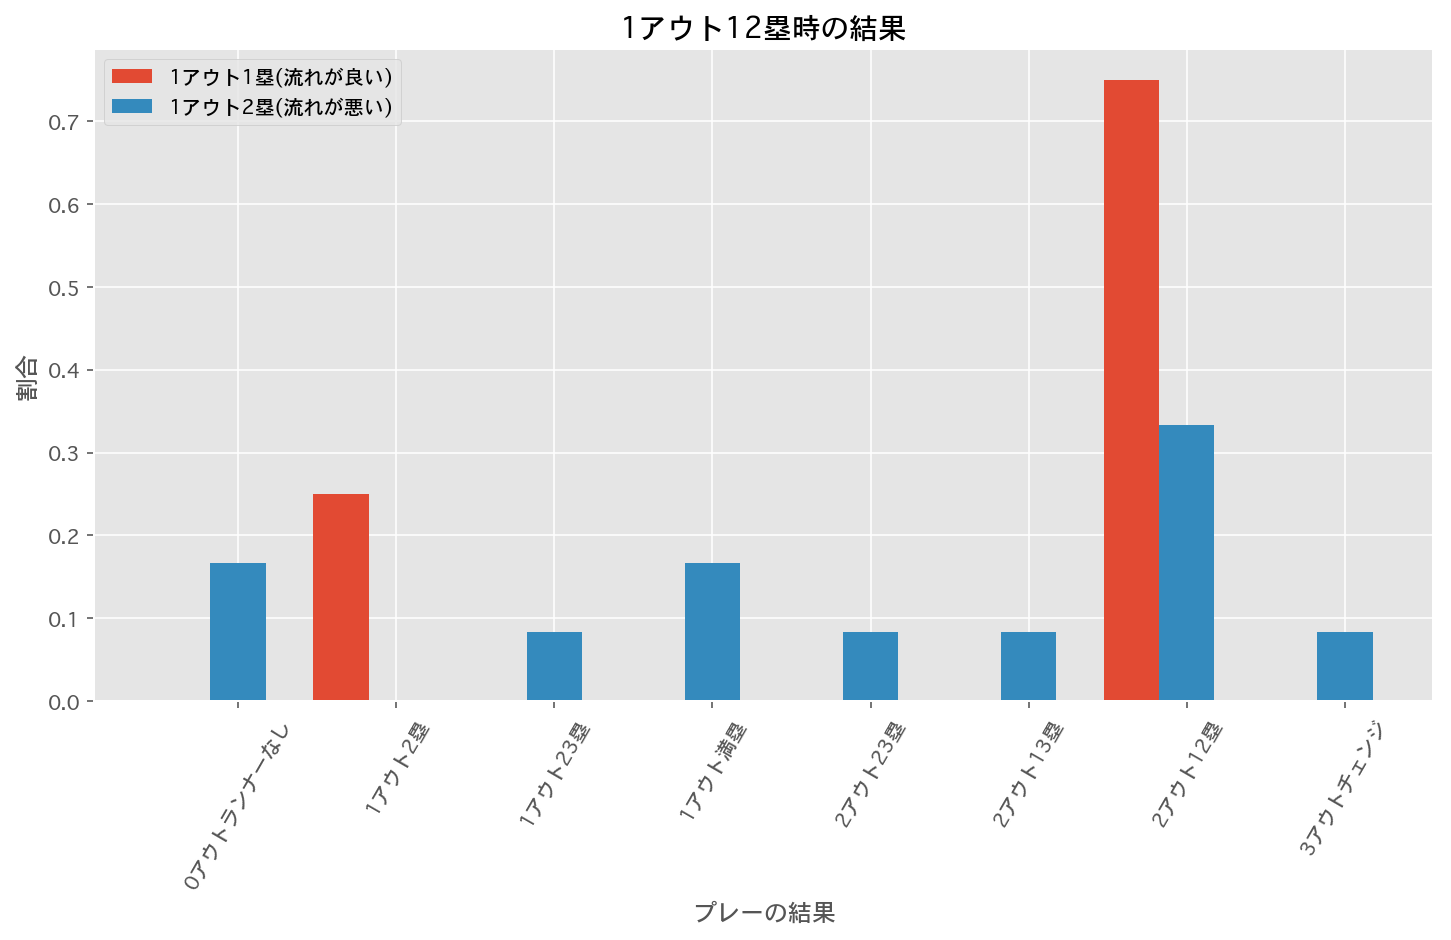

,ad_num,dis_num,ad_rate,dis_rate,pvalue
1アウト2塁,1,0,0.25,0.000000,0.082418
2アウト12塁,3,4,0.75,0.333333,0.166129
0アウトランナーなし,0,2,0.00,0.166667,0.416837
1アウト満塁,0,2,0.00,0.166667,0.416837
1アウト23塁,0,1,0.00,0.083333,0.581627
2アウト23塁,0,1,0.00,0.083333,0.581627
2アウト13塁,0,1,0.00,0.083333,0.581627
3アウトチェンジ,0,1,0.00,0.083333,0.581627


In [205]:
for inning in range(10):
    bar_and_df("1100", "1010", "1110", inning_triple_list[inning])

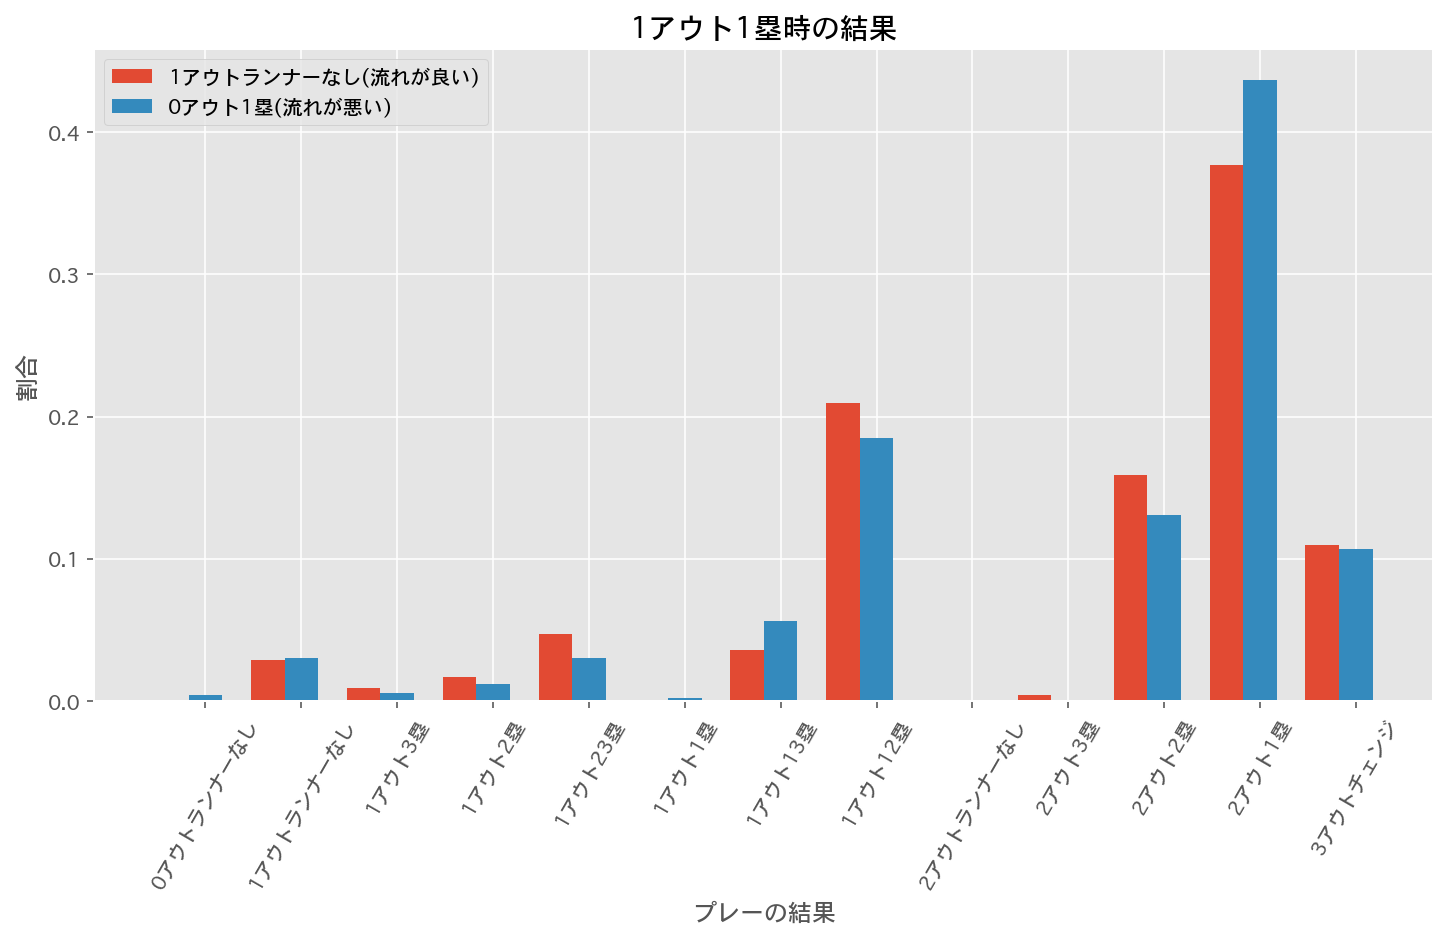

,ad_num,dis_num,ad_rate,dis_rate,pvalue
2アウト1塁,377,217,0.376623,0.436620,0.025410
1アウト13塁,36,28,0.035964,0.056338,0.066438
1アウト23塁,47,15,0.046953,0.030181,0.125078
2アウト2塁,159,65,0.158841,0.130785,0.151843
2アウト3塁,4,0,0.003996,0.000000,0.158411
0アウトランナーなし,1,2,0.000999,0.004024,0.217787
1アウト12塁,210,92,0.209790,0.185111,0.262571
1アウト2塁,17,6,0.016983,0.012072,0.467056
2アウトランナーなし,1,0,0.000999,0.000000,0.481224
1アウト3塁,9,3,0.008991,0.006036,0.546117


In [189]:
bar_and_df("1000", "0100", "1100", latter_triple)

In [28]:
# columns = before, index = after
"""
curr = "1000"
ba_list = []
for elem in triple_transfer_list:
    if elem[1] == curr:
        ba_list.append((elem[0], elem[2]))
ba_dict = defaultdict(list)
for elem in ba_list:
    ba_dict[elem[0]].append(elem[1])
df_list = []
for k, v in ba_dict.items():
    counter = Counter(v)
    _df = pd.DataFrame(list(counter.values()), index=list(counter.keys()))
    _df.columns = [k]
    df_list.append(_df)
df = pd.concat(df_list, join="outer", axis=1)
#length = len(df.columns)
for column in df.columns:
    plt.figure(figsize=(12, 6))
    plt.bar(list(range(len(df[column]))), df[column])
    plt.xticks(list(range(len(df[column]))), df.index)
    plt.legend()
    plt.title(column+"→"+curr)
    plt.show()
"""

'\ncurr = "1000"\nba_list = []\nfor elem in triple_transfer_list:\n    if elem[1] == curr:\n        ba_list.append((elem[0], elem[2]))\nba_dict = defaultdict(list)\nfor elem in ba_list:\n    ba_dict[elem[0]].append(elem[1])\ndf_list = []\nfor k, v in ba_dict.items():\n    counter = Counter(v)\n    _df = pd.DataFrame(list(counter.values()), index=list(counter.keys()))\n    _df.columns = [k]\n    df_list.append(_df)\ndf = pd.concat(df_list, join="outer", axis=1)\n#length = len(df.columns)\nfor column in df.columns:\n    plt.figure(figsize=(12, 6))\n    plt.bar(list(range(len(df[column]))), df[column])\n    plt.xticks(list(range(len(df[column]))), df.index)\n    plt.legend()\n    plt.title(column+"→"+curr)\n    plt.show()\n'

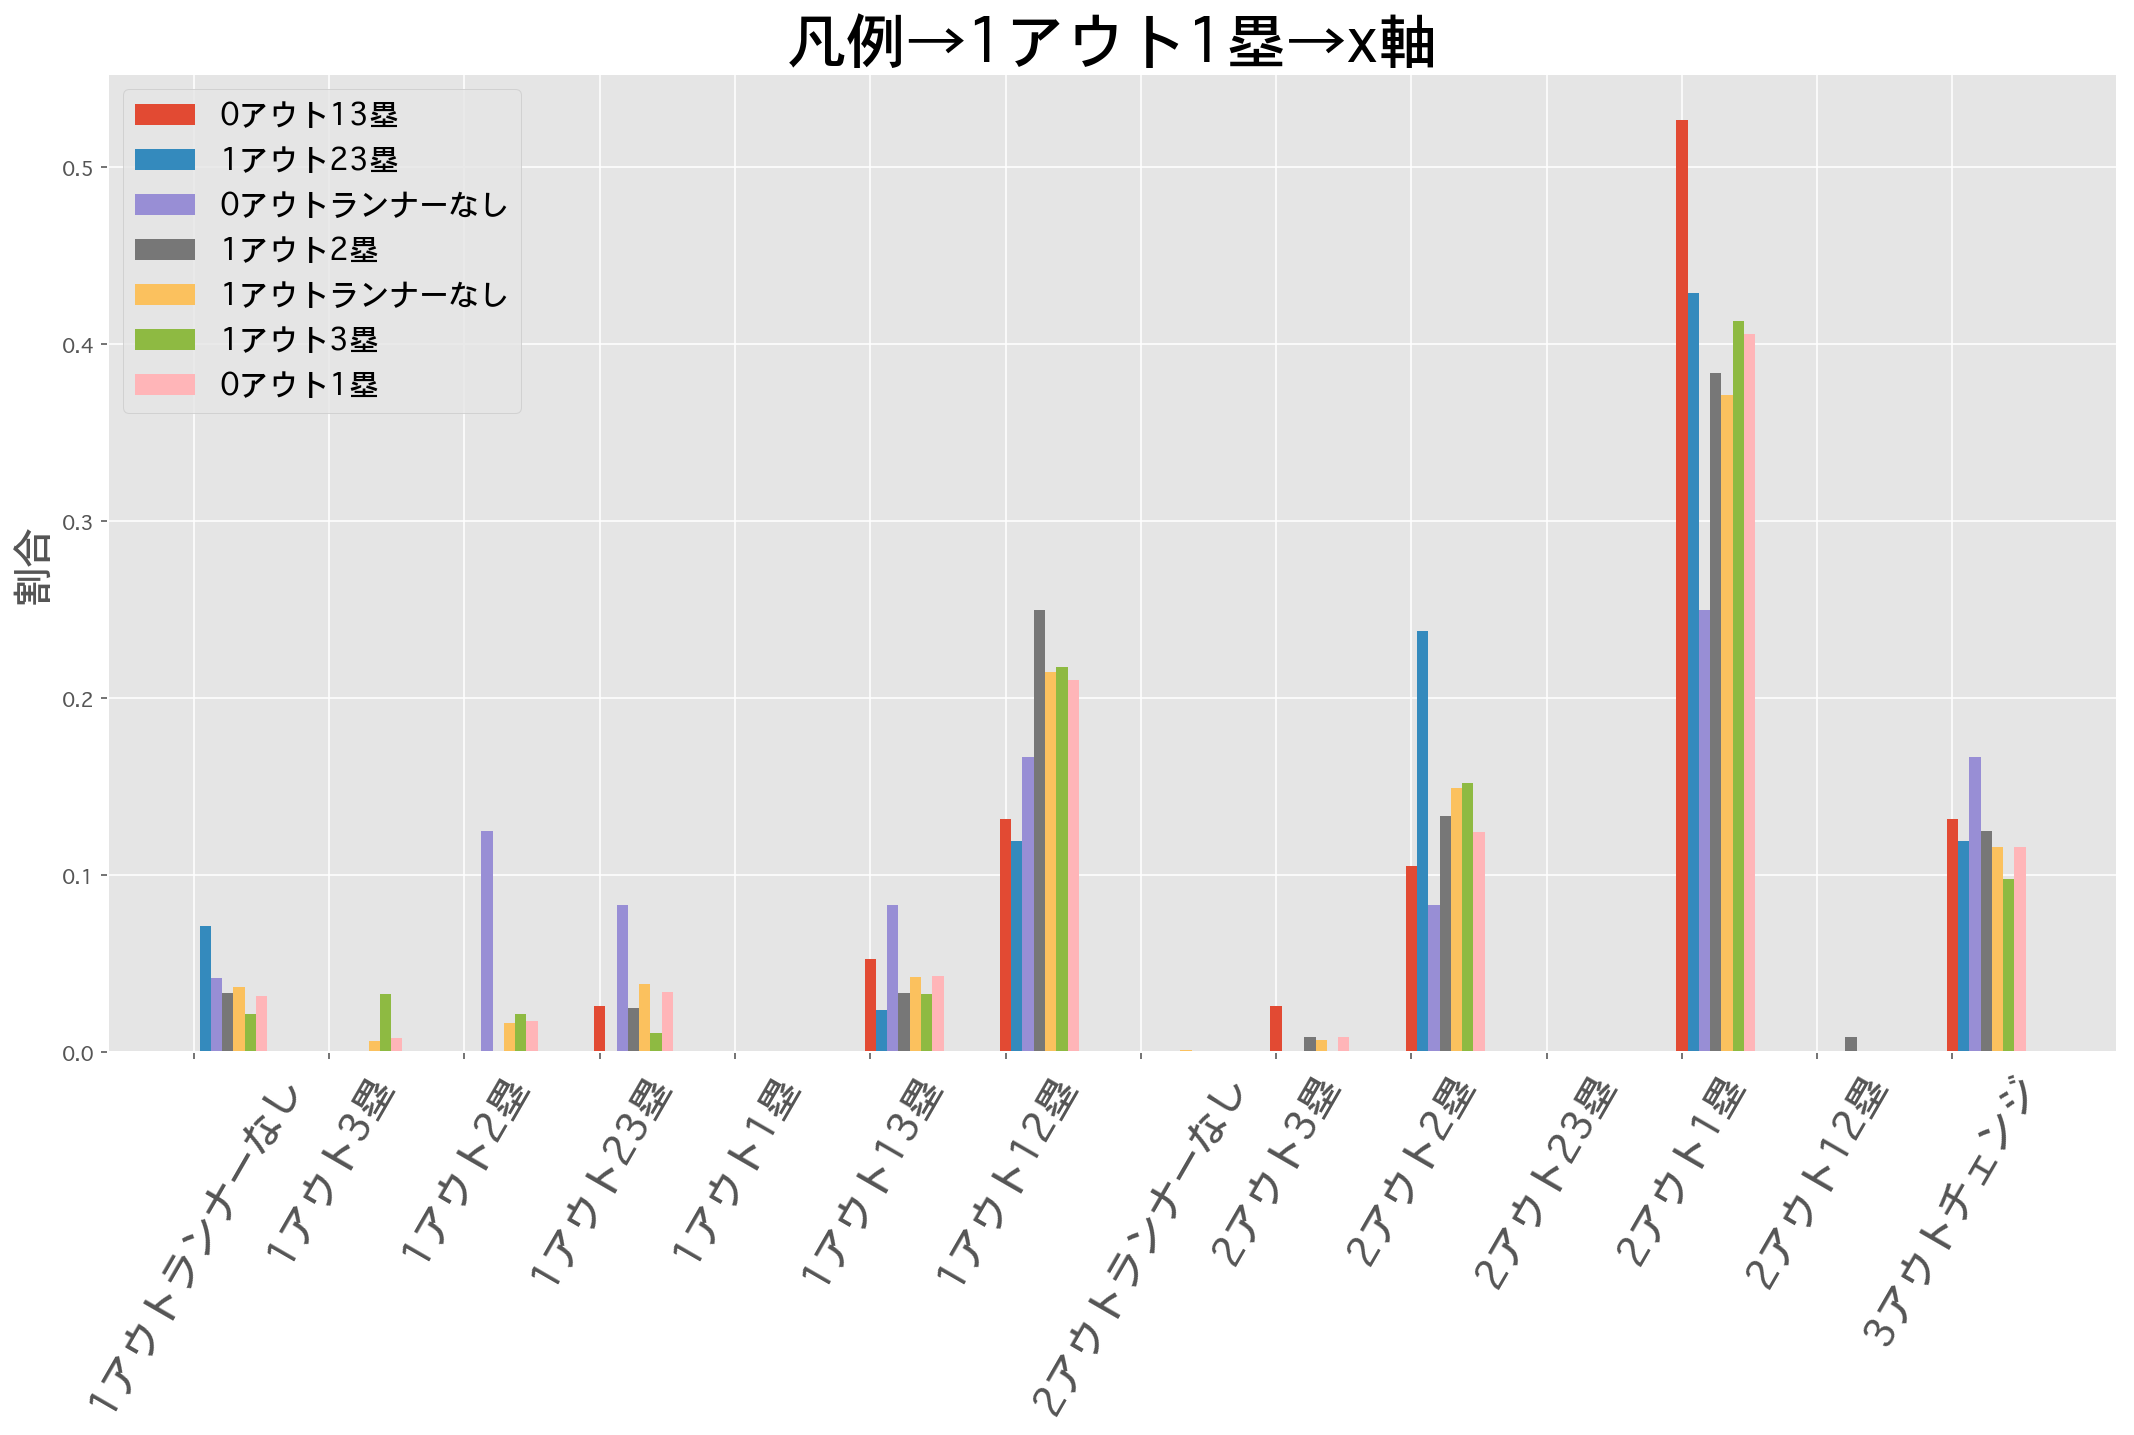

In [20]:
# columns = before, index = after
curr = "1100"
ba_list = []
for elem in triple_transfer_list:
    if elem[1] == curr:
        ba_list.append((elem[0], elem[2]))
ba_dict = defaultdict(list)
for elem in ba_list:
    ba_dict[elem[0]].append(elem[1])
df_list = []
for k, v in ba_dict.items():
    counter = Counter(v)
    _df = pd.DataFrame(list(counter.values()), index=list(counter.keys()))
    _df.columns = [k]
    df_list.append(_df)
df = pd.concat(df_list, join="outer", axis=1)
length = len(df.columns)
idx = 0
used_columns = []
plt.figure(figsize=(18, 9))
for column in df.columns:
    if df[column].sum() > 10:
        plt.bar(np.array(list(range(len(df[column]))))+idx*1/length, df[column]/df[column].sum(), width=1/length)
        idx += 1
        used_columns.append(column)
plt.xticks(list(range(len(df[column]))), [decode_count(index) for index in df.index], rotation=60, fontsize=20)
plt.legend([decode_count(column) for column in used_columns], loc="upper left", fontsize=15)
plt.title("凡例→"+decode_count(curr)+"→x軸", fontsize=30)
plt.ylabel("割合", fontsize=20)
plt.show()

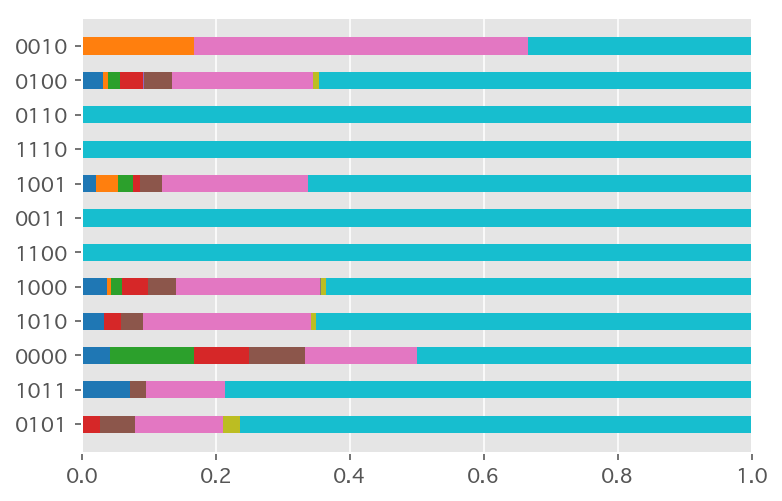

In [22]:
#plt.barh(left=[1, 2], height=[1, 1], width=[2, 4], bottom=[1, 2], alpha=0.5)
idx = 0
df = df.fillna(0)
for column in df.columns:
    cmap = plt.get_cmap("tab10")
    cum = 0
    s = df[column].sum()
    #print(column)
    i = 0
    for index in df[column].index:
        curr = df[column][index]
        #print(cum)
        plt.barh(left=[cum/s], height=[0.5], width=[curr/s], bottom=[idx], color=cmap(i))
        cum += curr
        i += 1
        #print(s)
    idx += 1
plt.yticks([idx for idx in range(len(df.columns))], df.columns)
plt.show()

In [109]:
curr = "1110"
before_set = set()
for elem in triple_transfer_list:
    if elem[1] == curr:
        before_set.add(elem[0])

In [110]:
ad_before_lst = [
    "0101",
    "0100",
]

dis_before_lst = [
    ""
]

In [111]:
before_set

{'0010',
 '0011',
 '0100',
 '0101',
 '0110',
 '0111',
 '1010',
 '1100',
 '1101',
 '1110',
 '1111'}

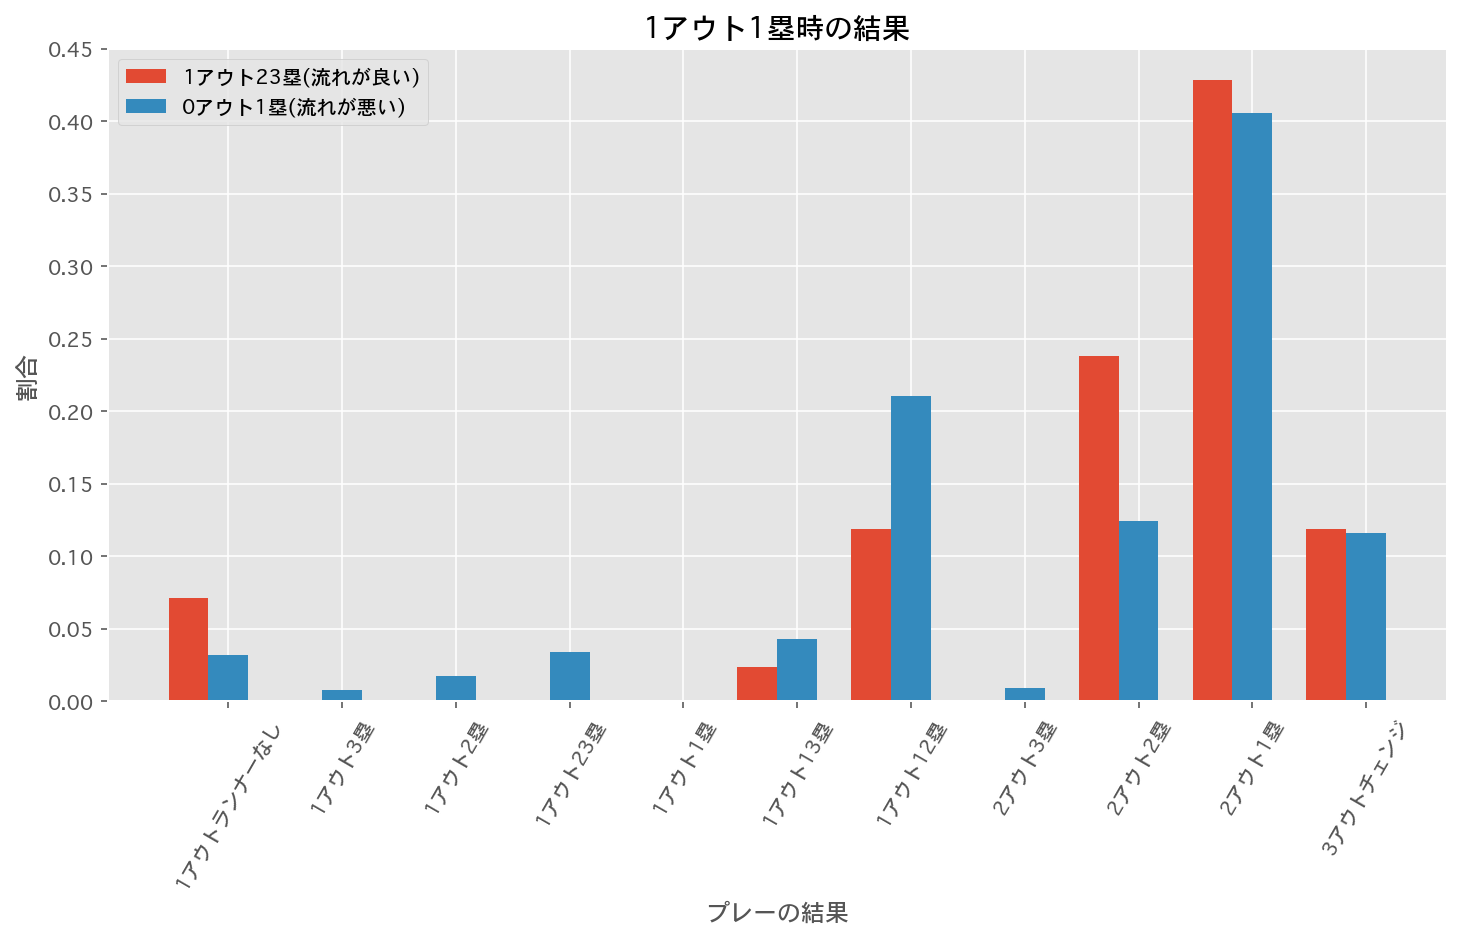

,ad_num,dis_num,ad_rate,dis_rate,pvalue
2アウト2塁,10,142,0.238095,0.124452,0.030670
1アウト12塁,5,240,0.119048,0.210342,0.151856
1アウトランナーなし,3,36,0.071429,0.031551,0.155438
1アウト23塁,0,39,0.000000,0.034181,0.223412
1アウト2塁,0,20,0.000000,0.017528,0.387265
2アウト3塁,0,10,0.000000,0.008764,0.542726
1アウト13塁,1,49,0.023810,0.042945,0.545352
1アウト3塁,0,9,0.000000,0.007888,0.563799
2アウト1塁,18,463,0.428571,0.405784,0.768029
1アウト1塁,0,1,0.000000,0.000876,0.847947


In [27]:
bar_and_df("1011", "0100", "1100")

In [9]:
# 2アウト3塁
#ad_before = "2000" 
#dis_before = "1001" 
#after = "2001"

# 1アウト3塁
#ad_before = "1000" 
#dis_before = "0001" 
#after = "1001"

# 2アウト2塁
#ad_before = "2000" 
#dis_before = "1010" 
#after = "2010"

# 1アウト2塁
#ad_before = "1000" 
#dis_before = "0010" 
#after = "1010"

# 2アウト1塁
#ad_before = "2000" 
#dis_before = "1100" 
#after = "2100"

# 1アウト1塁
#ad_before = "1000"
#dis_before = "0100"
#after = "1100"